# Setup

Let's import and initialize Spark, along with all the other libraries we're using (this might take a while).

In [1]:
# Uncomment these if do this homework locally
# See Homework 3 for details

#from local_install import setup_environment
#setup_environment() 

import folium
import pyspark
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import numpy as np
import os
%pylab inline
%pylab notebook

Extracting Spark
Populating the interactive namespace from numpy and matplotlib


ValueError: Unrecognized backend string "nbagg": valid strings are ['pdf', 'pgf', 'Qt4Agg', 'GTK', 'GTKAgg', 'ps', 'agg', 'cairo', 'MacOSX', 'GTKCairo', 'WXAgg', 'template', 'TkAgg', 'GTK3Cairo', 'GTK3Agg', 'svg', 'WebAgg', 'CocoaAgg', 'emf', 'gdk', 'WX']

In [2]:
sc = pyspark.SparkContext()
sql = pyspark.sql.SQLContext(sc)

# 1. DataFrames

## 1a. File Format Wrangling

### Begin Student Code Here

Implement the loading of data files into DataFrame objects. First, unzip the data file into a local folder whose path is stored in 'root_path'.

In [3]:
root_path = "./fec_2016_3_25"

# file_struct objects
com_file = {'header': "cm_header_file.csv", 'data': "cm.txt" }
can_file = {'header': "cn_header_file.csv", 'data': "cn.txt" }
com_can_link_file = {'header': "ccl_header_file.csv", 'data': "ccl.txt" }
indv_file = {'header': "indiv_header_file.csv", 'data': "itcont.txt" }
pas_file = {'header': "pas2_header_file.csv", 'data': "itpas2.txt" }
com_links_file = {'header': "oth_header_file.csv", 'data': "itoth.txt" }

def load_header(filename):
    """
    Given a header .csv file, return a list containing the names of all columns in the table.
    
    Input:
    filename: a string specifying the header .csv file to load
    
    Output:
    A list containing column names of the table
    """
    with open(filename, "r") as f:
        return [r.replace('\r\n','') for r in f.readline().split(",")]
    
def load_dataframe(file_struct):
    """
    Given a dictionary representing the locations of FEC raw files corresponding to a table,
    load the tables into a Spark DataFrame.
    
    Input:
    file_struct: a dictionary containing the keys 'header' and 'data', where
     'header' contains the name of the `.csv` file specifying the table header file, and
     'data' contains the name of the `.txt` file specifying the table data file
     
    Output:
    A DataFrame which contains the loaded data.
    """
    df = None
    # TODO
    #first we need to get all the headers and the data
    headers = load_header(root_path + "/" + file_struct['header'])
    data_lines = sc.textFile(root_path + "/" + file_struct['data'])
    #convert data_lines into tuple of data
    data  = data_lines.map(lambda t: t.split("|"))
    #make struct field from headers
    fields = []
    for header in headers :
        current_struct = StructField(header,StringType(),True)
        fields.append(current_struct)
    schema = StructType(fields)
    #give the schema to the data frame
    df =  sql.createDataFrame(data,schema)
    return df.cache()

### End Student Code Here

We'll load these files into Spark now, and register them as temporary SQL tables.

In [4]:
com = load_dataframe(com_file)
can = load_dataframe(can_file)
links = load_dataframe(com_can_link_file)
indv = load_dataframe(indv_file)
pas = load_dataframe(pas_file)
com_links = load_dataframe(com_links_file)

In [5]:
com.registerTempTable("com")
can.registerTempTable("can")
links.registerTempTable("links")
indv.registerTempTable("indv")
pas.registerTempTable("pas")
com_links.registerTempTable("com_links")

## 1b. Basic Analytics Queries

As a demonstration, let's query for information corresponding to the strings "Clinton", "Sanders", "Trump", and "Cruz". Try these queries. How does this output look?

In [6]:
front_runners = can.where(can.CAND_NAME.like("%CLINTON%") | can.CAND_NAME.like("%SANDERS%") 
          | can.CAND_NAME.like("%TRUMP%") | can.CAND_NAME.like("%CRUZ%") )\
    .select("CAND_ID", "CAND_NAME", "CAND_STATUS", "CAND_OFFICE")
front_runners.show(truncate=False)

+---------+-----------------------------------+-----------+-----------+
|CAND_ID  |CAND_NAME                          |CAND_STATUS|CAND_OFFICE|
+---------+-----------------------------------+-----------+-----------+
|H2CA24153|THAYNE, DAVID CRUZ                 |P          |H          |
|H2MI08105|HETRICK, BRIAN CLINTON             |N          |H          |
|H2TX33123|SANDERS, KENNETH                   |P          |H          |
|H6NY05051|SANDERS, JAMES JR                  |C          |H          |
|H6NY09137|SANDERS, JAIME                     |N          |H          |
|H8OH02041|SANDERS, CHARLES W                 |P          |H          |
|P00003392|CLINTON, HILLARY RODHAM            |C          |P          |
|P60006111|CRUZ, RAFAEL EDWARD "TED"          |C          |P          |
|P60007168|SANDERS, BERNARD                   |C          |P          |
|P60012184|BALLSACK, DONALD TRUMP'S HAIRY KING|N          |P          |
|P60012333|CLINTON, BILL                      |N          |P    

In [7]:
front_runners = sql.sql("""
SELECT CAND_ID, CAND_NAME, CAND_STATUS, CAND_OFFICE
FROM can
WHERE CAND_NAME LIKE "%CLINTON%"
OR CAND_NAME LIKE "%SANDERS%"
OR CAND_NAME LIKE "%TRUMP%"
OR CAND_NAME LIKE "%CRUZ%"
""")
front_runners.registerTempTable("fr")
front_runners.show(truncate=False)

+---------+-----------------------------------+-----------+-----------+
|CAND_ID  |CAND_NAME                          |CAND_STATUS|CAND_OFFICE|
+---------+-----------------------------------+-----------+-----------+
|H2CA24153|THAYNE, DAVID CRUZ                 |P          |H          |
|H2MI08105|HETRICK, BRIAN CLINTON             |N          |H          |
|H2TX33123|SANDERS, KENNETH                   |P          |H          |
|H6NY05051|SANDERS, JAMES JR                  |C          |H          |
|H6NY09137|SANDERS, JAIME                     |N          |H          |
|H8OH02041|SANDERS, CHARLES W                 |P          |H          |
|P00003392|CLINTON, HILLARY RODHAM            |C          |P          |
|P60006111|CRUZ, RAFAEL EDWARD "TED"          |C          |P          |
|P60007168|SANDERS, BERNARD                   |C          |P          |
|P60012184|BALLSACK, DONALD TRUMP'S HAIRY KING|N          |P          |
|P60012333|CLINTON, BILL                      |N          |P    

That didn't work out so well. But notice how both queries got the same results! For the rest of the questions, you are allowed to write the queries in either form. Use the DataFrames that you created in part 1a. They are listed again here for reference:

* **com** contains committee information [Details](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryCommitteeMaster.shtml)
* **can** contains candidate information [Details](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryCandidateMaster.shtml)
* **links** contains linkage between committees and candidates [Details](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryCandCmteLinkage.shtml)
* **indv** contains individual contributions to committees [Details](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryContributionsbyIndividuals.shtml)
* **pas** contains contributions between committees [Details](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryContributionstoCandidates.shtml)
* **com_links** links between committees [Details](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryCommitteetoCommittee.shtml)

### Begin Student Code Here

Q1.

In [15]:
front_runners = sql.sql("""
SELECT CAND_ID,CAND_NAME,CAND_PCC
FROM can
WHERE (CAND_NAME LIKE "%CLINTON%" OR CAND_NAME LIKE "%SANDERS%"
OR CAND_NAME LIKE "%TRUMP%" OR CAND_NAME LIKE "%CRUZ%")
AND CAND_OFFICE = "P" AND CAND_STATUS = "C"
""")
# TODO
front_runners.registerTempTable("Question_one")
q1 = front_runners
#.select("CAND_ID", "CAND_NAME", "CAND_PCC")
q1.show(truncate=False)

+---------+-------------------------+---------+
|CAND_ID  |CAND_NAME                |CAND_PCC |
+---------+-------------------------+---------+
|P00003392|CLINTON, HILLARY RODHAM  |C00575795|
|P60006111|CRUZ, RAFAEL EDWARD "TED"|C00574624|
|P60007168|SANDERS, BERNARD         |C00577130|
|P80001571|TRUMP, DONALD J          |C00580100|
+---------+-------------------------+---------+



**Q1 Expected Output:**
```
+---------+-------------------------+---------+
|CAND_ID  |CAND_NAME                |CAND_PCC |
+---------+-------------------------+---------+
|P00003392|CLINTON, HILLARY RODHAM  |C00575795|
|P60006111|CRUZ, RAFAEL EDWARD "TED"|C00574624|
|P60007168|SANDERS, BERNARD         |C00577130|
|P80001571|TRUMP, DONALD J          |C00580100|
+---------+-------------------------+---------+
```

Q2.

In [14]:
num_indv_contributions = sql.sql("""
SELECT CAND_ID,CAND_NAME,COUNT(*) AS count
FROM Question_one,indv
WHERE Question_one.CAND_PCC = indv.CMTE_ID
GROUP BY CAND_ID,CAND_NAME
""")
# TODO

q2 = num_indv_contributions
#.select("CAND_ID", "CAND_NAME", "count")
q2.show(truncate=False)

+---------+-------------------------+-----+
|CAND_ID  |CAND_NAME                |count|
+---------+-------------------------+-----+
|P80001571|TRUMP, DONALD J          |3006 |
|P60006111|CRUZ, RAFAEL EDWARD "TED"|34699|
|P60007168|SANDERS, BERNARD         |34524|
|P00003392|CLINTON, HILLARY RODHAM  |71249|
+---------+-------------------------+-----+



**Q2 Expected Output:**
```
+---------+-------------------------+-----+
|CAND_ID  |CAND_NAME                |count|
+---------+-------------------------+-----+
|P80001571|TRUMP, DONALD J          |3006 |
|P60006111|CRUZ, RAFAEL EDWARD "TED"|34699|
|P60007168|SANDERS, BERNARD         |34524|
|P00003392|CLINTON, HILLARY RODHAM  |71249|
+---------+-------------------------+-----+
```

Q3.

In [13]:
indv_contributions_amt = sql.sql("""
SELECT CAND_ID,CAND_NAME,SUM(TRANSACTION_AMT) AS sum
FROM Question_one,indv
WHERE indv.CMTE_ID = Question_one.CAND_PCC
GROUP BY CAND_ID,CAND_NAME
ORDER BY sum
""").withColumnRenamed("sum","sum(TRANSACTION_AMT)")

# TODO

# We will also accept a solution in either format.
# Be sure to comment out the one you don't use: 
# q3 = indv_contributions_amt.select("CAND_ID", "CAND_NAME", "SUM")
q3 = indv_contributions_amt
#.select("CAND_ID", "CAND_NAME", "count")
q3.show(truncate=False)

+---------+-------------------------+--------------------+
|CAND_ID  |CAND_NAME                |sum(TRANSACTION_AMT)|
+---------+-------------------------+--------------------+
|P80001571|TRUMP, DONALD J          |1994976.0           |
|P60006111|CRUZ, RAFAEL EDWARD "TED"|2.4785175E7         |
|P60007168|SANDERS, BERNARD         |4.9001141E7         |
|P00003392|CLINTON, HILLARY RODHAM  |9.5996062E7         |
+---------+-------------------------+--------------------+



**Q3 Expected Output:**
```
+---------+-------------------------+--------------------+
|CAND_ID  |CAND_NAME                |sum(TRANSACTION_AMT)|
+---------+-------------------------+--------------------+
|P80001571|TRUMP, DONALD J          |1994976.0           |
|P60006111|CRUZ, RAFAEL EDWARD "TED"|2.4785175E7         |
|P60007168|SANDERS, BERNARD         |4.9001141E7         |
|P00003392|CLINTON, HILLARY RODHAM  |9.5996062E7         |
+---------+-------------------------+--------------------+
```

Q4.

In [18]:
linked_committees = sql.sql("""
SELECT S1.CAND_NAME,S1.CAND_ID,S2.CMTE_ID,S2.CMTE_NM
FROM Question_one AS S1, com AS S2
WHERE S1.CAND_ID = S2.CAND_ID
""")
# TODO
q4 = linked_committees.select("CAND_NAME", "CAND_ID", "CMTE_ID", "CMTE_NM")
q4.show(truncate=False)

+-------------------------+---------+---------+-------------------------------------------------------------------------------+
|CAND_NAME                |CAND_ID  |CMTE_ID  |CMTE_NM                                                                        |
+-------------------------+---------+---------+-------------------------------------------------------------------------------+
|CLINTON, HILLARY RODHAM  |P00003392|C00570978|FUTURE OF AMERICAN LIVES MATTER                                                |
|CRUZ, RAFAEL EDWARD "TED"|P60006111|C00574624|CRUZ FOR PRESIDENT                                                             |
|CLINTON, HILLARY RODHAM  |P00003392|C00575795|HILLARY FOR AMERICA                                                            |
|SANDERS, BERNARD         |P60007168|C00577130|BERNIE 2016                                                                    |
|CLINTON, HILLARY RODHAM  |P00003392|C00577395|PEOPLE IN COMMAND/PIC                                    

**Q4 Expected Output:**
```
+-------------------------+---------+---------+-------------------------------------------------------------------------------+
|CAND_NAME                |CAND_ID  |CMTE_ID  |CMTE_NM                                                                        |
+-------------------------+---------+---------+-------------------------------------------------------------------------------+
|CLINTON, HILLARY RODHAM  |P00003392|C00577395|PEOPLE IN COMMAND/PIC                                                          |
|SANDERS, BERNARD         |P60007168|C00590646|NEW YORK CAPITAL REGION FOR BRINGING ECONOMIC REVOLUTION NOW INSPIRING EVERYONE|
|SANDERS, BERNARD         |P60007168|C00612549|LORAIN COUNTY FORWARD                                                          |
|CLINTON, HILLARY RODHAM  |P00003392|C00575795|HILLARY FOR AMERICA                                                            |
|SANDERS, BERNARD         |P60007168|C00587766|SILVER CITY NM FOR BERNIE SANDERS                                              |
|SANDERS, BERNARD         |P60007168|C00588707|ITHACA AND TOMPKINS COUNTY FOR BERNIE SANDERS                                  |
|SANDERS, BERNARD         |P60007168|C00589937|PROGRESSGJ                                                                     |
|SANDERS, BERNARD         |P60007168|C00588434|ROCHESTER FOR PROGRESS                                                         |
|SANDERS, BERNARD         |P60007168|C00577130|BERNIE 2016                                                                    |
|CRUZ, RAFAEL EDWARD "TED"|P60006111|C00574624|CRUZ FOR PRESIDENT                                                             |
|SANDERS, BERNARD         |P60007168|C00590828|UPPER VALLEY FOR BERNIE SANDERS                                                |
|CRUZ, RAFAEL EDWARD "TED"|P60006111|C00612119|CRUZ INFO PRESIDENT                                                            |
|SANDERS, BERNARD         |P60007168|C00583708|PROGRESS WV                                                                    |
|SANDERS, BERNARD         |P60007168|C00582395|UPSTATE NEW YORK FOR BERNIE SANDERS                                            |
|SANDERS, BERNARD         |P60007168|C00590620|LAS CRUCES FOR BERNIE                                                          |
|CLINTON, HILLARY RODHAM  |P00003392|C00570978|FUTURE OF AMERICAN LIVES MATTER                                                |
|TRUMP, DONALD J          |P80001571|C00580100|DONALD J. TRUMP FOR PRESIDENT, INC.                                            |
|SANDERS, BERNARD         |P60007168|C00590240|NORTHEAST MUSICIANS FOR SOCIAL DEMOCRACY                                       |
+-------------------------+---------+---------+-------------------------------------------------------------------------------+
```

Q5.

In [19]:
num_com_contributions = sql.sql("""
SELECT Question_one.CAND_NAME,COUNT(pas.CMTE_ID) as count
FROM Question_one,pas
WHERE Question_one.CAND_ID = pas.CAND_ID
GROUP BY CAND_NAME
""")
# TODO
q5 = num_com_contributions.select("CAND_NAME", "count")
q5.show(truncate=False)

+-------------------------+-----+
|CAND_NAME                |count|
+-------------------------+-----+
|CLINTON, HILLARY RODHAM  |2561 |
|SANDERS, BERNARD         |1577 |
|TRUMP, DONALD J          |333  |
|CRUZ, RAFAEL EDWARD "TED"|643  |
+-------------------------+-----+



**Q5 Expected Output:**

```
+-------------------------+-----+
|CAND_NAME                |count|
+-------------------------+-----+
|CLINTON, HILLARY RODHAM  |2561 |
|SANDERS, BERNARD         |1577 |
|TRUMP, DONALD J          |333  |
|CRUZ, RAFAEL EDWARD "TED"|643  |
+-------------------------+-----+
```

Q6.

In [20]:
com_contributions_amt = sql.sql("""
SELECT S1.CAND_NAME,SUM(TRANSACTION_AMT) AS sum
FROM Question_one AS S1,pas AS S2
WHERE S1.CAND_ID = S2.CAND_ID
GROUP BY S1.CAND_NAME
""").withColumnRenamed("sum","sum(TRANSACTION_AMT)")
# TODO

# We will also accept a solution in either format.
# Be sure to comment out the one you don't use: 
# q6 = com_contributions_amt.select("CAND_NAME", "SUM")
q6 = com_contributions_amt.select("CAND_NAME", "sum(TRANSACTION_AMT)")
q6.show(truncate=False)

+-------------------------+--------------------+
|CAND_NAME                |sum(TRANSACTION_AMT)|
+-------------------------+--------------------+
|CLINTON, HILLARY RODHAM  |6064499.0           |
|SANDERS, BERNARD         |1202034.0           |
|TRUMP, DONALD J          |6099777.0           |
|CRUZ, RAFAEL EDWARD "TED"|1.2145601E7         |
+-------------------------+--------------------+



**Q6 Expected Output:**

```
+-------------------------+--------------------+
|CAND_NAME                |sum(TRANSACTION_AMT)|
+-------------------------+--------------------+
|CLINTON, HILLARY RODHAM  |6064499.0           |
|SANDERS, BERNARD         |1202034.0           |
|TRUMP, DONALD J          |6099777.0           |
|CRUZ, RAFAEL EDWARD "TED"|1.2145601E7         |
+-------------------------+--------------------+
```

### End Student Code Here

# 2. K-means Clustering

## Use Dataframe API to load some Toy Data

Load a parquet file as a DataFrame.

In [21]:
df = sql.read.parquet("toy_data")

Let's look at a few records:

In [22]:
df.show()

+----------+----------+
|         x|         y|
+----------+----------+
| 2.5455968|-2.4678698|
|  5.393343| 2.0226636|
|-2.6967278|   6.04135|
| 3.2742562| -4.329741|
|-2.8346312|  -5.55185|
|-6.8219104| -6.216632|
| 5.0789514| -5.723718|
|-4.4893827| -4.817831|
| -8.568877| 7.4704356|
| 3.7725136|  9.647934|
| 4.3655133| 3.8768165|
|  6.376908|-5.4031186|
|-2.5573678| 1.1811672|
| -4.261156|-6.8115454|
|  5.919376|  5.560924|
| -8.474529| -6.686147|
|  5.281597| 3.2823496|
|  6.865725| 2.0507808|
|   5.62337| -5.642469|
|  8.332024|-7.2829323|
+----------+----------+
only showing top 20 rows



## Plotting the Toy Data

We'll first plot a sample of some toy data. Let's collect a sample of records,

In [23]:
sample = df.sample(False, 0.2)

project out the `x` and the `y` columns,

In [24]:
x_sample = sample.select('x').collect()
y_sample = sample.select('y').collect()

and plot the data.

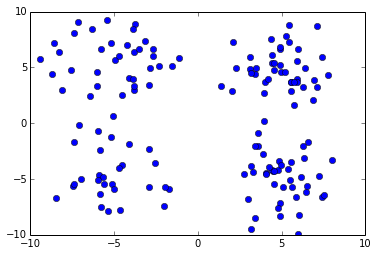

In [25]:
plt.figure()
plt.axis([-10, 10, -10, 10])
plot(x_sample, y_sample, 'bo')

## Implementation

Implement a distributed version of K-Means clustering using PySpark.

## 2a. K-Means++ Initialization

Initialize the centers using the K-Means++ Algorithm, using Distributed Reservoir Sampling. We've provided you the signatures of a few functions which may be helpful.

### Begin Student Code Here

In [144]:
def initialize_centers_plus(points, k):
    """
    Find k initial cluster centers using distributed weighted reservoir sampling.
    
    Inputs:
    points: a collection of d-dimensional points (x_1, x_2, ..., x_d).
    k: the number of cluster centers wanted
    
    Output:
    A list of k points which become the initial centers in K-means clustering
    """
    
    
    # Choose first center uniformly at random
    #first we should replace point with a map
    points = points.map(lambda x: x)
    #take the centers randomly
    centers = points.takeSample(True,1)
    #centers.append(points.takeSample(False,1,seed=0)[0])
    
    for _ in range(1, k):
        # Compute distances of each point to its nearest center, and
        #new_center = points.mapPartitions(distances).mapPartitions(choose_partition_center).reduce(pick_between_centers)
        new_center = points.map(lambda point: (point, nearest_center(centers, point)[1] ** 2)).mapPartitions(choose_partition_center).reduce(pick_between_centers)
        
        centers.append(new_center[0])
        
    return centers

In [145]:
def choose_partition_center(points_partition_iterator):
    """
    Choose a single center from a SINGLE PARTITION, using weighted random sampling.
    
    Inputs:
    points_partition_iterator: an iterator through a partition of D-dimensional points
    
    Output:
    (As an iterator) A 2-tuple, containing the randomly-chosen center and its weighted random-sampling key
    """
    center = None
    key = None
    # TODO
    #first we should traverse all the points 
    for point,weight in points_partition_iterator:
        tmp_key = 0
        if weight != 0:
            tmp_key = np.random.uniform(0,1,size=1)[0] ** (float(1)/(weight ** 2))
        if key == None or tmp_key > key :
            center = point
            key = tmp_key 
    yield (center, key)

In [146]:
def pick_between_centers(candidate_center_1, candidate_center_2):
    """
    Between two centers from different partitions, pick the one with a larger key.
    
    Inputs:
    candidate_center_1: a 2-tuple, containing the randomly-chosen center and its weighted random sampling key 
                        from the first partition
    candidate_center_2: a 2-tuple, containing the randomly-chosen center and its weighted random sampling key 
                        from the first partition
    
    Output:
    A 2-tuple, containing the "better" center and its weighted random-sampling key
    """
    better_center = None
    if candidate_center_1[1] >= candidate_center_2[1]:
        better_center = candidate_center_1
    else:
        better_center = candidate_center_2
    
    
    return better_center

In [147]:
def nearest_center(centers, point):
    """
    Given a point and a list of centers (also points), determine the center closest to that point,
    and compute the distance to that point.
    
    Inputs:
    centers: a list of points which represent the current centers
    point: the point to examine
    
    Outputs:
    A 2-tuple, containing the index of the closest center (point) and its distance from point
    """
    (index, shortest_distance) = (None, None)
    # TODO
    all_distance = np.linalg.norm(np.subtract(centers,point),axis=1)
   # shortest_distance = np.amin(all_distance)
    index = np.argmin(all_distance)
    shortest_distance = all_distance[index]
    
    return (index, shortest_distance)

### End Student Code Here

## Plotting the centers

Let's see how our initialization algorithm performs. How do your centers look? Are they too close to each other?

[Row(x=-7.234499931335449, y=-5.999726295471191), Row(x=5.287578105926514, y=7.796891689300537), Row(x=-7.9223127365112305, y=5.01663064956665), Row(x=7.327786445617676, y=-3.469661235809326)]


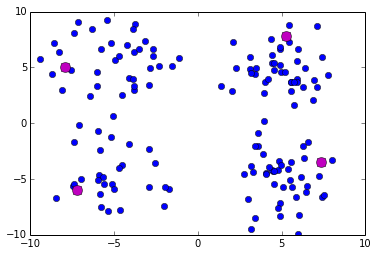

In [148]:
num_centers = 4
centers = initialize_centers_plus(df, num_centers)
print centers 

plt.figure()
plt.axis([-10, 10, -10, 10])
plot(x_sample, y_sample, 'bo')
centers = np.asarray(centers)
plt.plot(centers[:,0], centers[:,1], 'mo', markersize = 10)

## 2b. Main Loop

Now, implement the main loop in K-means clustering. Again, we've provided you the signatures of some functions which may be useful.

Note: The statistics of a new center "mean" is given by:
$$
\bar{x}_k = \frac{1}{n_k} \sum_{x \in \text{Cluster}[k]}^{n_i} x
$$
So the only statistics we require are $n_k$ the number of elements in cluster $k$ and $\sum_{x \in \text{Cluster}[k]}^{n_i} x$ the sum of the elements in cluster $k$.

### Begin Student Code Here

In [149]:
def k_means(points,
            k = num_centers,
            initial_centers = None,
            max_iterations = 100,
            initializer = initialize_centers_plus,
            epsilon = 0.001):
    """
    Executes the K-means algorithm on a collection of points.
    
    Inputs:
    points: a collection of d-dimensional points (x_1, x_2, ..., x_d).
    k: the number of cluster centers wanted
    initial_centers: if supplied, skips the initialization phase and uses points from this value
    max_iterations: the maximum number of main-loop iterations to run
    initializer: a function which selects initial centers (if none supplied)
    epsilon: the threshhold at which convergence is reached and the algorithm halted
    
    Output:
    A list of k candidate cluster centers
    """
    #always first convert the points to the map
    points.map(lambda x: x)
    # speeds up rerunning
    points.cache()
    
    old_centers = None
    new_centers = None
    if initial_centers: # we were provided initial centers to use
        new_centers = initial_centers
    else: # we need to initialize the centers ourselves
        # TODO
        new_centers = initializer(points,k)
        
    iteration = 0
    while not has_converged(old_centers, new_centers, epsilon) and iteration < max_iterations:
        # update centers
        # TODO
        old_centers = new_centers
        #now we should compute the new center statistics
        #new_statistics = points.mapPartitions(lambda iter: compute_new_center_statistics(iter,old_centers)).reduce(add_statistics)
        #counts = new_statistics[0]
        #sums = new_statistics[1]
        new_centers = [np.zeros(len(old_centers[0])) for i in range(k)]
        new_stats = points.mapPartitions(lambda iterate: compute_new_center_statistics(iterate, old_centers)).reduce(add_statistics)
        i = 0
        while i < k:
            new_centers[i] = new_stats[1][i] / new_stats[0][i]
            i = i + 1
        iteration += 1
        
    return new_centers

In [150]:
def compute_new_center_statistics(iterator, old_centers):
    """
    Given an iterator over points and a list of old centers, compute the statistics for the new center.
    
    Input:
    iterator: an iterator over points
    old_centers: a list of centers (points) from the previous iteration
    
    Output:
    A 2-tuple (counts, sums) consisting of:
     - counts: an array of length k containing the count of points in each new center
     - sums: a k by d array consisting of sum of the points assigned to each center
     
    Note that from the tuple you could compute the ith new center:
      sums[i] / counts[i]
    """
    # Get the shape of the old centers
    k = len(old_centers)
    d = len(old_centers[0])
    
    # Initialize the sums
    # TODO
    counts = np.zeros(k)
    sums = np.zeros([k,d])
    
    # Loop over the data and compute the new assignments
    # TODO
    for point in iterator:
        # Compute the nearest center (you just implemented this!)
        # TODO
        index = nearest_center(old_centers,point)[0]
        # Update the sums and counts
        # TODO
        counts[index] = counts[index] + 1
        sums[index] = sums[index] + point

    yield (counts, sums)

In [151]:
def add_statistics(stats_1, stats_2):
    """
    Given statistics from two partitions, add those statistics.
    """
    stats = (None, None)
    # Compute stats_1 + stats_2
    # TODO
    stats = (stats_1[0] + stats_2[0],stats_1[1] + stats_2[1])
    return stats

### End Student Code Here

In [152]:
def has_converged(old_centers, new_centers, epsilon):
    """
    Test if the distance between the centers is less than epsilon.
    """
    return (old_centers is not None) and (new_centers is not None) and \
        np.linalg.norm(np.asarray(old_centers) - np.asarray(new_centers), ord=2) < epsilon

## Plotting Clusters

How does your code perform? Are these good clusters?

In [153]:
colors = ['ro', 'bo', 'go', 'yo'] # for now just use 4 colors

def plot_clusters(centers, plt):
    for i in range(num_centers):
        cluster = df.rdd.filter(lambda x: nearest_center(centers, x)[0] == i)
        cluster_sample = np.asarray(cluster.sample(False, 0.2).collect())
        plt.plot(cluster_sample[:,0], cluster_sample[:,1], colors[i])
    

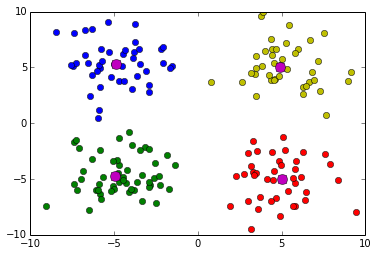

In [154]:
plt.figure()
plt.axis([-10, 10, -10, 10])

centers = k_means(df, num_centers)
plot_clusters(centers, plt)

centers = np.asarray(centers)
plt.plot(centers[:,0], centers[:,1], 'mo', markersize = 10)


# 3. Geographical Contribution Clustering

Let's put everything together! First we'll load the required data files.

In [155]:
zip_codes = sql.read.parquet("zip_codes")

Now we'll grab the relevant data we need. We'll join the table of front runners we collected earlier with their contributors' zip codes to get latitudinal and longitudinal data...

In [156]:
contrib_zips = \
    front_runners.join(indv, front_runners.CAND_PCC == indv.CMTE_ID) \
    .select("CAND_NAME", "CAND_ID", "ZIP_CODE")
contrib_zips = contrib_zips.withColumn("SHORT_ZIP", contrib_zips.ZIP_CODE.substr(0,5))

In [157]:
contrib_locs = \
    contrib_zips.join(zip_codes, contrib_zips.SHORT_ZIP == zip_codes.zip) \
    .select("CAND_NAME", "latitude", "longitude").cache()

In [158]:
candidate_names = [x[0] for x in contrib_locs.select("CAND_NAME").distinct().collect()]
candidate_names

[u'CLINTON, HILLARY RODHAM',
 u'SANDERS, BERNARD',
 u'TRUMP, DONALD J',
 u'CRUZ, RAFAEL EDWARD "TED"']

In [159]:
X = {}
for candidate in candidate_names:
    X[candidate] = contrib_locs.where(contrib_locs.CAND_NAME == candidate) \
        .select("latitude", "longitude") \
        .map(lambda r: np.array([x for x in r])) \
        .coalesce(sc.defaultParallelism).cache()

...which will allow us to plot these locations.

In [160]:
maps = {}
for candidate in X:
    maps[candidate] = folium.Map(location=[40, -100],
           tiles='Stamen Toner',
           zoom_start=4)
    locs = X[candidate].sample(False, 0.01).collect()
    for l in locs:
        folium.Marker(l).add_to(maps[candidate])

In [161]:
maps[u'CRUZ, RAFAEL EDWARD "TED"']

We can run k-means for each candidate. What's a good value for $k$? Run the K-means algorithm you developed earlier with different values of $k$ to determine the best one.

### Begin Student Code Here

In [162]:
def compute_errors(candidate_locations, k_range):
    def reduction(a, b):
            return a + b
    errors = {}
    for c in candidate_locations:
        errors[c] = []
        for k in k_range:
            # For each candidate, test multiple values of k
            centers = k_means(candidate_locations[c],k)
            #all_distance = (candidate_locations[c]).mapPartitions(distances).reduce(add_statistics)
            #current_error = all_distance[1] / all_distance[0]
            all_distance = candidate_locations[c].map(lambda x: nearest_center(centers, x)[1]).reduce(reduction)
            current_error = all_distance / candidate_locations[c].count()
            errors[c].append(current_error)
    return errors

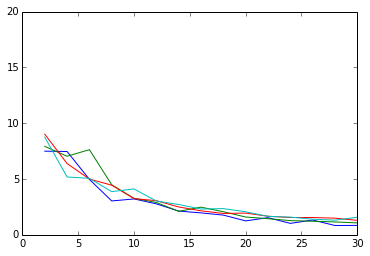

In [164]:
plt.figure()
plt.axis([0, 30, 0, 20])
k_range = range(2, 32, 2)
errors = compute_errors(X, k_range)
for c in errors:
    plot(k_range, errors[c])

Now that you've found a suitable value for k, run K-means to compute the desired clusters.

In [165]:
centers = {}
k = 9 # TODO enter the value you found here
for c in X:
    # Find the cluster centers for each candidate
    # TODO
    centers[c] = k_means(X[c],k)

### End Student Code Here

At last, we have the clusters we want. Here's a nifty visualization.

In [166]:
colors = dict(zip(centers.keys(), ['blue', 'green','orange', 'red']))
centers_map = folium.Map(location=[40, -100],
                         zoom_start=4)
for candidate in centers: 
    locs = centers[candidate]
    for l in locs:
        folium.Marker(l,
                      popup=str(l),
                      icon=folium.Icon(color=colors[candidate])).add_to(centers_map)
centers_map

Congratulations! You've successfully implemented a scalable machine learning algorithm on dataset of campaign finance contributions!